Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [1]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_forward"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = ['FKAccuracy','HeadingAccuracy',
       'ShortPassing',  'Dribbling',  
        'BallControl',  'SprintSpeed', 
       'Reactions',    'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision'
]
# PLAYER_ATTRIBUTES = [ 'shooting','ShortPassing','Dribbling','BallControl',
#                      'Speed',  'Reactions', 'Aggression','mental','age_based_Stamina','Positioning', 'Vision']
# PLAYER_ATTRIBUTES = [ 'Finishing',   'LongShots','ShotPower',   'Volleys',   'FKAccuracy',  'HeadingAccuracy',
#                       'Positioning', 'Vision' ,'ShortPassing','LongPassing',
#                      'BallControl','Dribbling', 
#                       'Acceleration', 'SprintSpeed', 'Agility','Reactions', 
#                       'Balance', 'Stamina','Jumping','Composure']


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2023/12/08 21:12:55 INFO mlflow.tracking.fluent: Experiment with name 'offense_potential_forward' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/289111135741430438', creation_time=1702066375350, experiment_id='289111135741430438', last_update_time=1702066375350, lifecycle_stage='active', name='offense_potential_forward', tags={}>

### Get Data

In [3]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [4]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,NaN,95.0,25.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0


# 

In [5]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [6]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [7]:
df = df[(df.central == 1)&(df.offense == 1)]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
78.0    30
75.0    28
77.0    23
74.0    21
76.0    20
73.0    20
72.0    16
70.0    14
69.0    13
81.0    12
84.0    12
79.0    11
71.0    11
80.0    11
68.0    10
83.0     9
82.0     9
64.0     9
67.0     8
66.0     5
65.0     3
88.0     3
89.0     3
87.0     3
86.0     2
63.0     2
85.0     1
91.0     1
92.0     1
90.0     1
62.0     1
57.0     1
Name: count, dtype: int64


In [8]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
186405,F. di Santo,2011,21.0,21.0,27.0,90.0,90.0,74.0,77.0,77.0,drop,ST
199266,Ji Dong Won,2011,19.0,19.0,22.0,89.0,89.0,66.0,72.0,72.0,drop,ST
253002,G. Raspadori,2022,21.0,21.0,22.0,88.0,88.0,74.0,79.0,79.0,valid,ST
240833,Y. Moukoko,2023,17.0,17.0,18.0,88.0,88.0,69.0,77.0,77.0,valid,ST
231677,M. Rashford,2017,18.0,18.0,25.0,88.0,88.0,76.0,84.0,84.0,train,ST


In [9]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [10]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Att. Position', 'Composure', 'Defensive awareness'], dtype='object')

#### Transform Value

In [11]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

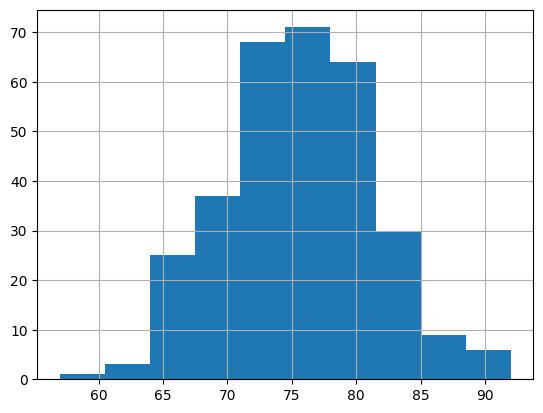

In [12]:
df['target'].hist()

In [13]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [14]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Att. Position', 'Composure', 'Defensive awareness', 'max_potential',
       'prime_age', 'PrimeOverall', 'best_position', 'central', 'winger',
       'offense', 'Defense', 'set', 'target'],
      dtype='object')

In [15]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [16]:
y_train.describe()

count    149.000000
mean      75.993289
std        5.342963
min       57.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       89.000000
Name: target, dtype: float64

In [17]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [18]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [19]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [20]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


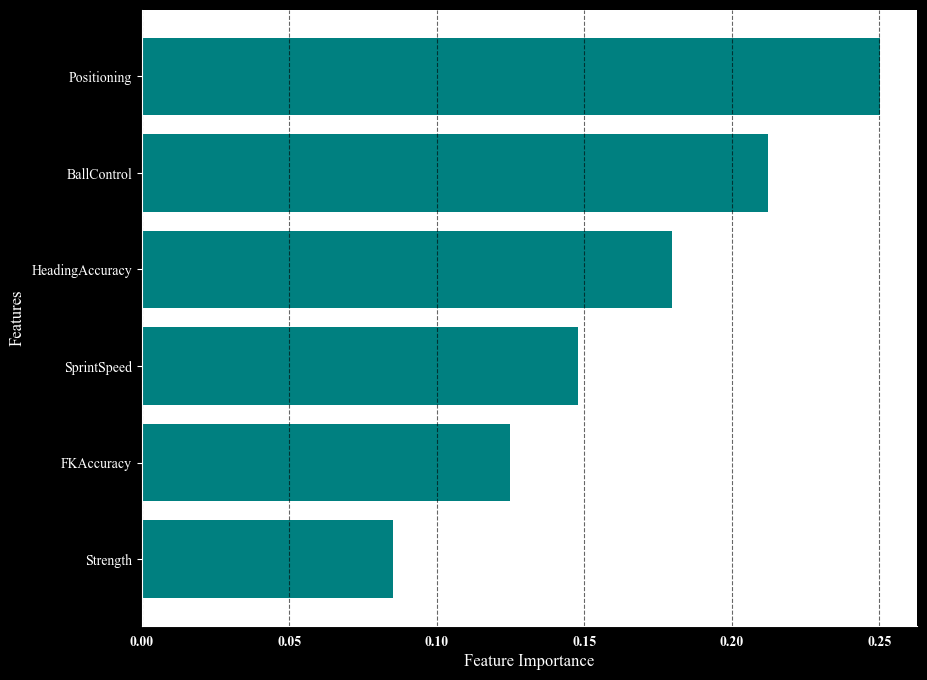

100%|██████████| 30/30 [00:01<00:00, 18.90it/s]


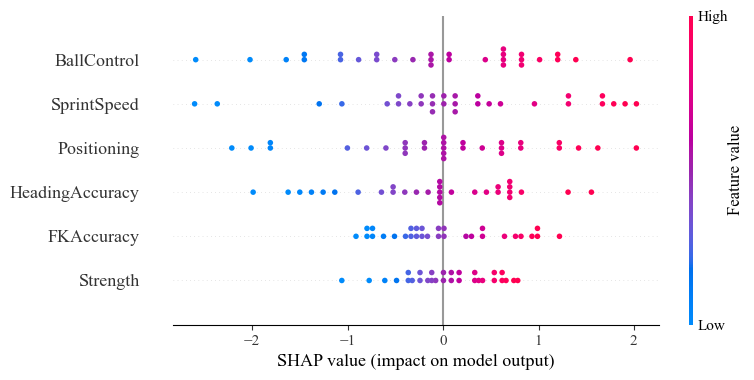

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        55
        True       0.20      0.20      0.20         5

    accuracy                           0.87        60
   macro avg       0.56      0.56      0.56        60
weighted avg       0.87      0.87      0.87        60

Huber Regression training----->


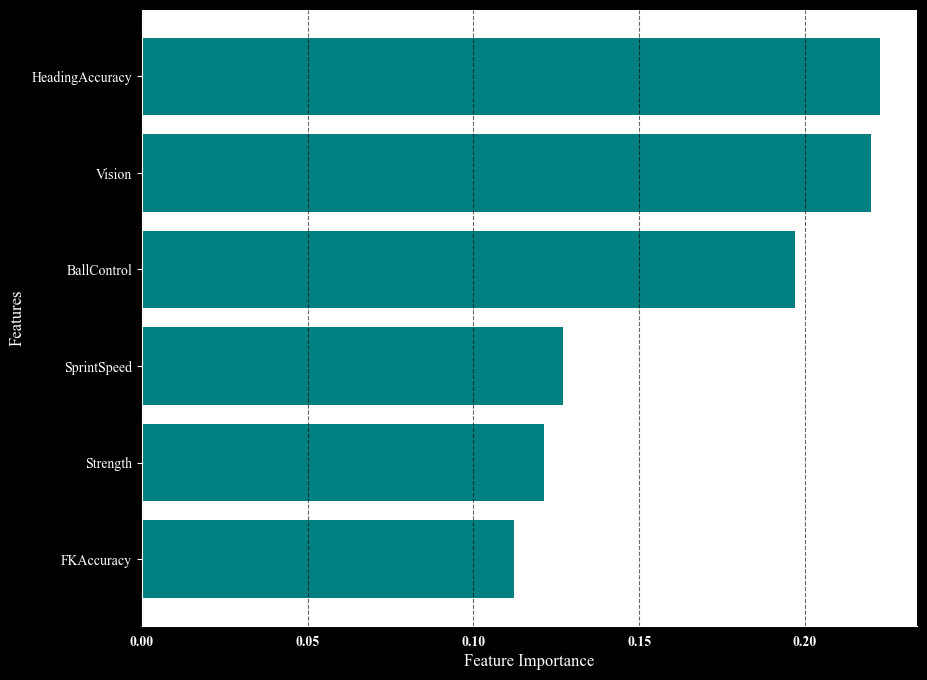

100%|██████████| 30/30 [00:01<00:00, 16.07it/s]


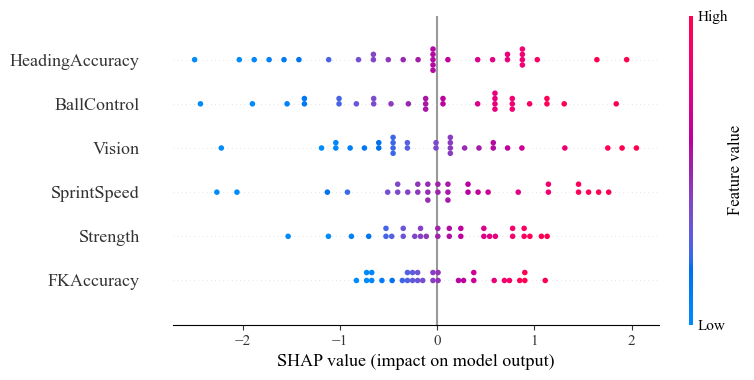

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        55
        True       0.20      0.20      0.20         5

    accuracy                           0.87        60
   macro avg       0.56      0.56      0.56        60
weighted avg       0.87      0.87      0.87        60

Linear Regression training----->


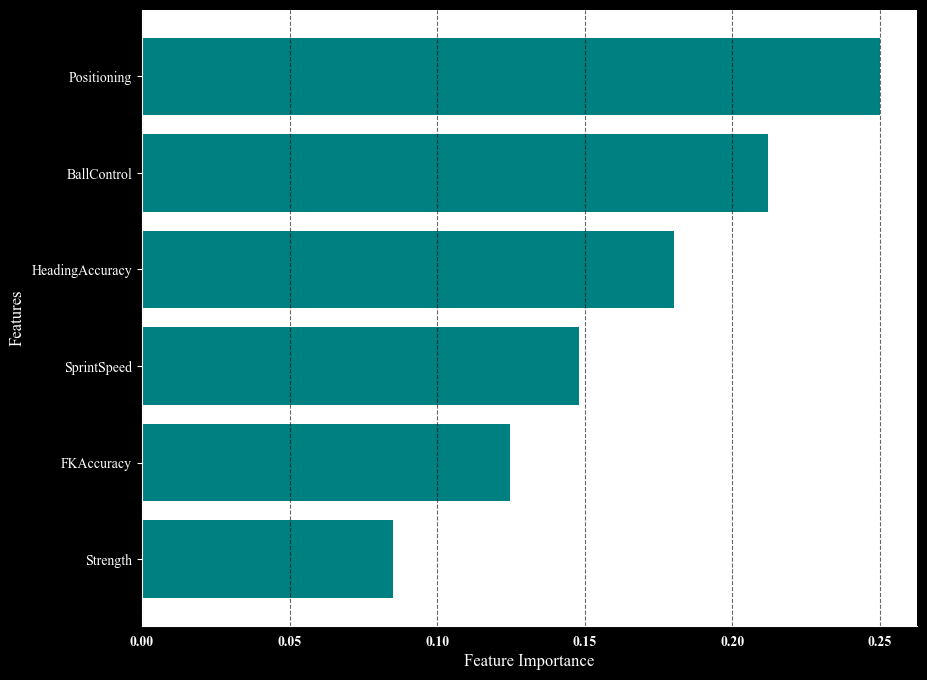

100%|██████████| 30/30 [00:02<00:00, 13.52it/s]


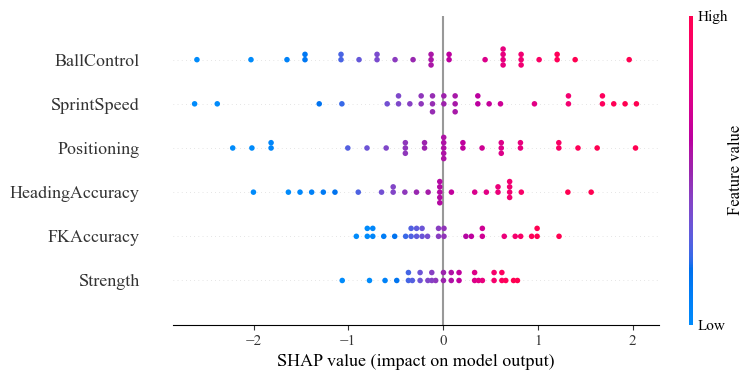

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        55
        True       0.20      0.20      0.20         5

    accuracy                           0.87        60
   macro avg       0.56      0.56      0.56        60
weighted avg       0.87      0.87      0.87        60

Model: Ridge Regression
Mean Squared Error: 17.18
Mean Absolute Error: 3.48
R2 Score: 0.41

Model: Huber Regression
Mean Squared Error: 17.87
Mean Absolute Error: 3.44
R2 Score: 0.39

Model: Linear Regression
Mean Squared Error: 17.16
Mean Absolute Error: 3.48
R2 Score: 0.41



In [21]:



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [22]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [23]:
X_train.describe()

,FKAccuracy,HeadingAccuracy,ShortPassing,Dribbling,BallControl,SprintSpeed,Reactions,Strength,LongShots,Aggression,Positioning,Vision
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.00000,149.000000,149.000000,149.000000
mean,46.644295,62.208054,61.436242,69.724832,69.872483,77.845638,65.214765,63.939597,61.42953,48.382550,68.161074,58.174497
std,13.184283,8.954295,8.198815,8.118929,6.811446,7.572822,7.976794,12.617142,7.69104,13.689904,7.546314,9.202476
min,22.000000,33.000000,41.000000,47.000000,51.000000,55.000000,45.000000,27.000000,42.00000,26.000000,51.000000,34.000000
25%,36.000000,57.000000,56.000000,64.000000,66.000000,74.000000,59.000000,57.000000,56.00000,35.000000,62.000000,52.000000
50%,42.000000,62.000000,61.000000,70.000000,70.000000,78.000000,65.000000,65.000000,61.00000,48.000000,68.000000,58.000000
75%,56.000000,69.000000,67.000000,75.000000,74.000000,84.000000,71.000000,73.000000,67.00000,58.000000,74.000000,64.000000
max,78.000000,78.000000,81.000000,90.000000,87.000000,93.000000,82.000000,91.000000,78.00000,81.000000,85.000000,79.000000


In [24]:
y_test.describe()

count    60.000000
mean     73.583333
std       5.456427
min      63.000000
25%      69.750000
50%      73.000000
75%      77.250000
max      91.000000
Name: target, dtype: float64

In [25]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [26]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

60

<Axes: >

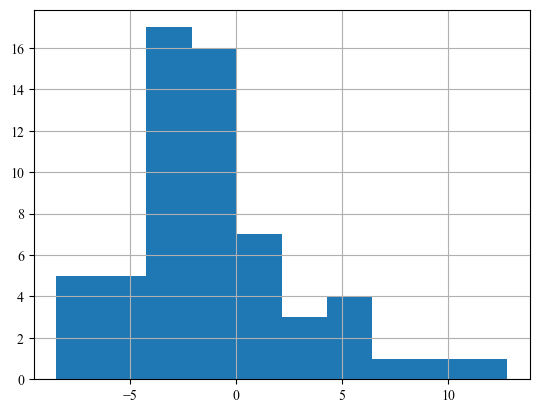

In [27]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

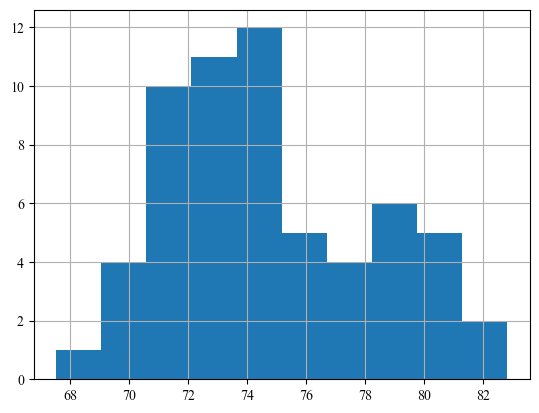

In [28]:
result_df.sort_values(ascending=False).hist()

In [29]:
(y_test-result_df).describe()

count    60.000000
mean     -1.127348
std       4.108735
min      -8.483308
25%      -3.186405
50%      -1.885012
75%       0.820210
max      12.787273
dtype: float64

In [30]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,FKAccuracy,HeadingAccuracy,ShortPassing,Dribbling,BallControl,SprintSpeed,Reactions,Strength,LongShots,Aggression,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,
241721,Rafael Leão,2020,58.0,58.0,67.0,77.0,75.0,86.0,73.0,77.0,62.0,59.0,78.0,69.0
246191,J. Álvarez,2020,66.0,60.0,63.0,68.0,72.0,78.0,66.0,40.0,59.0,32.0,65.0,60.0
239085,E. Håland,2020,51.0,62.0,67.0,72.0,74.0,83.0,72.0,84.0,62.0,81.0,73.0,57.0
248805,Sergio Camello,2020,34.0,61.0,62.0,65.0,66.0,64.0,64.0,47.0,60.0,27.0,67.0,54.0
253072,D. Núñez,2021,61.0,73.0,61.0,69.0,70.0,79.0,67.0,79.0,68.0,61.0,70.0,48.0
256853,M. Tillman,2021,32.0,59.0,57.0,62.0,62.0,65.0,54.0,59.0,59.0,41.0,57.0,53.0
246430,D. Vlahović,2021,37.0,68.0,60.0,70.0,72.0,66.0,68.0,68.0,64.0,50.0,74.0,54.0
238616,Pedro Neto,2020,40.0,51.0,60.0,70.0,71.0,78.0,65.0,40.0,62.0,32.0,64.0,56.0
252324,Riquelme,2020,44.0,46.0,62.0,63.0,64.0,64.0,62.0,47.0,59.0,58.0,65.0,61.0


In [31]:
y_test[outlier]

ID      Name            FIFA
241721  Rafael Leão     2020    86.0
246191  J. Álvarez      2020    80.0
239085  E. Håland       2020    91.0
248805  Sergio Camello  2020    75.0
253072  D. Núñez        2021    82.0
256853  M. Tillman      2021    74.0
246430  D. Vlahović     2021    84.0
238616  Pedro Neto      2020    78.0
252324  Riquelme        2020    78.0
Name: target, dtype: float64

In [32]:
result_df[outlier]

ID      Name            FIFA
241721  Rafael Leão     2020    79.807835
246191  J. Álvarez      2020    75.656472
239085  E. Håland       2020    78.212727
248805  Sergio Camello  2020    71.144724
253072  D. Núñez        2021    77.676082
256853  M. Tillman      2021    70.687100
246430  D. Vlahović     2021    74.894731
238616  Pedro Neto      2020    72.144895
252324  Riquelme        2020    70.044939
dtype: float64

In [33]:
(y_test/result_df).describe()

count    60.000000
mean      0.984816
std       0.054900
min       0.882962
25%       0.956349
50%       0.973604
75%       1.010410
max       1.163494
dtype: float64

In [34]:
(y_test/result_df).describe()

count    60.000000
mean      0.984816
std       0.054900
min       0.882962
25%       0.956349
50%       0.973604
75%       1.010410
max       1.163494
dtype: float64

In [35]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.65831536],
       [0.65831536, 1.        ]])

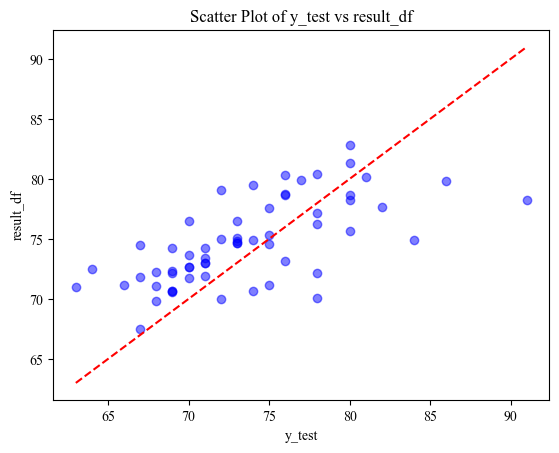

In [36]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [37]:
result_df = result_df.sort_values(ascending=False)

In [38]:
result_df.head(50)

ID      Name              FIFA
221479  D. Calvert-Lewin  2020    82.801955
231447  D. Malen          2020    81.316157
251470  C. De Ketelaere   2021    80.433336
241522  J. Wind           2021    80.325994
243630  J. David          2020    80.170124
235866  C. Kouamé         2020    79.897228
241721  Rafael Leão       2020    79.807835
233732  D. Okereke        2020    79.463009
251756  R. Nteka          2021    79.042713
245158  L. Suárez         2021    78.783927
244797  P. Musa           2021    78.651491
251852  K. Adeyemi        2021    78.638303
246186  Arthur Cabral     2021    78.247310
239085  E. Håland         2020    78.212727
253072  D. Núñez          2021    77.676082
245940  S. Wamangituka    2020    77.560601
244622  Puado             2020    77.183012
247888  S. Esposito       2021    76.502447
252042  João Pedro        2021    76.460094
246147  M. Greenwood      2020    76.231926
246191  J. Álvarez        2020    75.656472
246762  S. Koita          2021    75.352694
2

In [39]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


ID      Name              FIFA
221479  D. Calvert-Lewin  2020    82.801955
231447  D. Malen          2020    81.316157
243630  J. David          2020    80.170124
dtype: float64

In [40]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

7


ID      Name           FIFA
241721  Rafael Leão    2020    79.807835
251852  K. Adeyemi     2021    78.638303
246186  Arthur Cabral  2021    78.247310
239085  E. Håland      2020    78.212727
253072  D. Núñez       2021    77.676082
246191  J. Álvarez     2020    75.656472
246430  D. Vlahović    2021    74.894731
dtype: float64

In [41]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

4


ID      Name              FIFA
221479  D. Calvert-Lewin  2020    82.801955
231447  D. Malen          2020    81.316157
251470  C. De Ketelaere   2021    80.433336
241522  J. Wind           2021    80.325994
dtype: float64

In [42]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

48


ID      Name            FIFA
245762  A. Kutucu       2020    74.239808
254849  Y. Badji        2021    74.482466
238900  E. Demirović    2021    74.576701
250961  J. Zirkzee      2020    74.664696
239025  I. Niane        2020    74.682928
252037  Fábio Silva     2020    74.796516
246728  L. Traoré       2020    74.905238
225668  K. Grant        2020    74.996923
243315  Dani Gómez      2020    75.062933
246762  S. Koita        2021    75.352694
246147  M. Greenwood    2020    76.231926
252042  João Pedro      2021    76.460094
247888  S. Esposito     2021    76.502447
244622  Puado           2020    77.183012
245940  S. Wamangituka  2020    77.560601
244797  P. Musa         2021    78.651491
245158  L. Suárez       2021    78.783927
251756  R. Nteka        2021    79.042713
233732  D. Okereke      2020    79.463009
235866  C. Kouamé       2020    79.897228
dtype: float64

In [43]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.68      0.62      0.65        40
        True       0.35      0.40      0.37        20

    accuracy                           0.55        60
   macro avg       0.51      0.51      0.51        60
weighted avg       0.57      0.55      0.56        60

